In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 


from qiskit import Aer
from qiskit import QuantumCircuit, execute

from qiskit.visualization import plot_histogram
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from scipy.optimize import minimize
%matplotlib inline

{(0, 1): Text(0.7024844288825989, 0.3847779016941786, '1'),
 (0, 2): Text(0.634913831949234, 0.12277430109679699, '1'),
 (1, 2): Text(0.5660776197910309, 0.48680025339126587, '1'),
 (1, 3): Text(0.4158555418252945, 0.7546672821044922, '1'),
 (2, 3): Text(0.3482849448919296, 0.4926636815071106, '1')}

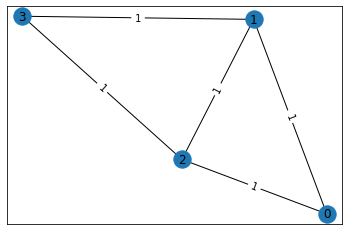

In [8]:
##########  Custom Graph   ############

w = np.array([[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]])

G = nx.from_numpy_matrix(w)
layout = nx.random_layout(G, seed=10)
labels = nx.get_edge_attributes(G, 'weight')
E = G.edges()
V = list(G.nodes()) 
nx.draw_networkx(G, pos=layout)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

In [9]:
potential = []


def qaoa(theta):  # Main QAOA circuit
    #print("\n\n\n Parametrized angles are :\n {}\n\n".format(theta))
    p = int(len(theta)/2)     # Circuit depth
    theta = theta.reshape(p,2)
    

    # Inintializing Quantum and classical registers
    QAOA = QuantumCircuit(len(V), len(V))

    QAOA.h(range(len(V)))
    QAOA.barrier()
    for i in range(p):
        beta, gamma = theta[i,0],theta[i,1]
        # Operator for problem hamiltonian (Ising type)
        for edge in E:
            k = edge[0]
            l = edge[1]

            QAOA.cx(k,l)
            QAOA.rz(2*gamma,l)
            QAOA.cx(k,l)   
            
        # Gates for Mixer hamiltonian
        QAOA.rx(2*beta, range(len(V)))
        QAOA.barrier()

    # Final measurement in the computational basis
    QAOA.measure(range(len(V)),range(len(V)))
    return QAOA





def measurement_simulator(theta):
    circuit = qaoa(theta)
    simulate     = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=1000)
    results = simulate.result()
    counts = results.get_counts()
    best_sample = most_likely_sample(counts)
    cost_value = avg_cost(counts,G)
    potential.append(cost_value)
    print("Expectation value is:{}           Most likely sample in this measurement ---> {}".format(cost_value,best_sample,))
    return cost_value,potential





def avg_cost(counts,G):  # Return average cost of all bitstring in a measurement
    energy = 0
    for sample in list(counts.keys()):
        x = [int(num) for num in list(sample)]
        C = cost(x,G)
        #print(x,':------------',C)
        energy += counts[sample]*C
    return energy/sum(counts.values())




def cost(x,G):       # Return cost for a single bitsring
    E = G.edges()
    if (len(x) != len(G.nodes())):
        return np.nan
    C = 0
    for index in E:
        e1,e2 = index[0],index[1]
        
        w = G[e1][e2]['weight']
        C += w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return -C




def most_likely_sample(counts):   # Returns most likely sample from counts
    X = list(counts.keys())
    Y = list(counts.values())
    idx = Y.index(max(Y))
    x = X[idx]
    return x



def str_2_array(z):  # Returns bitarray frm bitstring
    x = []
    for i in z:
        x.append(int(i))
    return np.array(x)


Expectation value is:-1.059           Most likely sample in this measurement ---> 0000
Expectation value is:-2.804           Most likely sample in this measurement ---> 0110
Expectation value is:-2.54           Most likely sample in this measurement ---> 1110
Expectation value is:-2.029           Most likely sample in this measurement ---> 1111
Expectation value is:-1.061           Most likely sample in this measurement ---> 1111
Expectation value is:-2.941           Most likely sample in this measurement ---> 0110
Expectation value is:-2.495           Most likely sample in this measurement ---> 1001
Expectation value is:-2.509           Most likely sample in this measurement ---> 0011
Expectation value is:-3.151           Most likely sample in this measurement ---> 0110
Expectation value is:-3.173           Most likely sample in this measurement ---> 1001
Expectation value is:-2.855           Most likely sample in this measurement ---> 1001
Expectation value is:-3.138           Most l

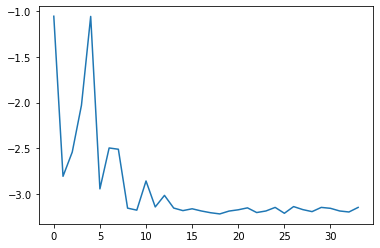

In [10]:
######## Running QAOA on simulator   

depth = 1 # depth of the circuit


theta = np.random.rand(2*depth)
solution = minimize(measurement_simulator,theta, method='COBYLA')
print("\n\nOptimization complete:\n",solution)
########################### 


plt.plot(range(len(potential)),potential)
plt.show()

Most likely sample:0110    and with Optimal cost: -4


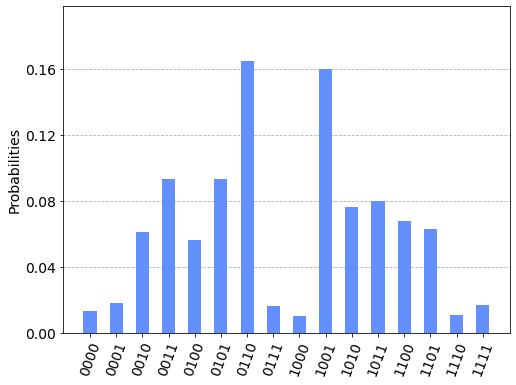

In [11]:
###########  QAOA result on simulator  ##########

theta_optimal = np.array(solution.x).flatten()
circuit = qaoa(theta_optimal)

simulate = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=1000)
QAOA_results = simulate.result()
best_solution = most_likely_sample(QAOA_results.get_counts())
print('Most likely sample:{}    and with Optimal cost: {}'.format(best_solution,cost(str_2_array(best_solution),G)))
plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

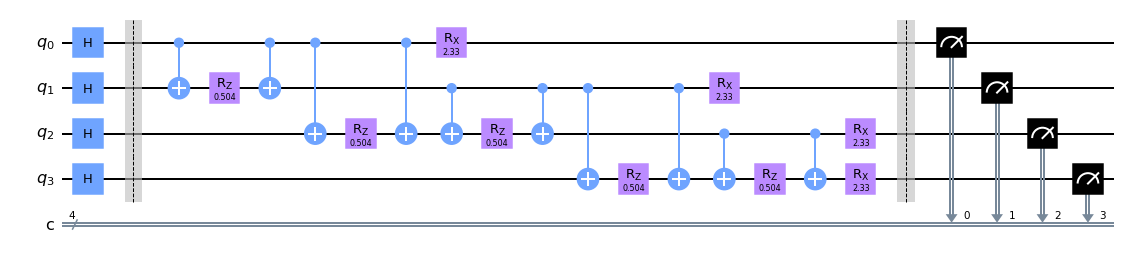

In [12]:
circuit = qaoa(theta_optimal)
circuit.draw('mpl')